In [1]:
import os
import psycopg
import pandas as pd
from dotenv import load_dotenv
load_dotenv()

TABLE_NAME = "users_churn"

connection = {"target_session_attrs": "read-write"}#"sslmode": "verify-full"
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}
connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

df.head(2)

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,...,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,17,8191-XWSZG,2015-10-01,NaT,One year,No,Mailed check,20.65,1022.95,None,...,None,None,None,None,Female,0,No,No,No,0
1,59,3957-SQXML,2017-04-01,NaT,Two year,No,Credit card (automatic),24.95,894.30,None,...,None,None,None,None,Female,0,Yes,Yes,Yes,0


In [2]:
from sklearn.model_selection import train_test_split

features = [
    'paperless_billing',
    'payment_method',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'multiple_lines',
    "monthly_charges",
    "total_charges"
]

target = 'target'

split_column = "begin_date"
test_size = 0.2

df = df.sort_values(by=[split_column])

X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df[target],
    test_size=test_size,
    shuffle=False,
) 

In [3]:
from autofeat import AutoFeatClassifier

cat_features = [
    'paperless_billing',
    'payment_method',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'multiple_lines',
]
num_features = ["monthly_charges", "total_charges"]

features = cat_features + num_features

transformations = ('1/', 'log', 'abs', 'sqrt')

afc = AutoFeatClassifier(
    categorical_cols=cat_features,
    transformations=transformations,
    feateng_steps=1,
    n_jobs=-1
)

X_train_features = afc.fit_transform(X_train, y_train)
X_test_features = afc.transform(X_test)

## Задача №1

In [58]:
import os
import mlflow
import psycopg
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


#TABLE_NAME = "users_churn"
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "churn_fio"
RUN_NAME = "feature_selection"
REGISTRY_MODEL_NAME = "churn_model_fio"
FS_ASSETS = "fs_assets" 

In [8]:
estimator = RandomForestClassifier(n_estimators=3)

sfs = SFS(
    estimator, 
    k_features=10, 
    forward=True, 
    floating=False, 
    scoring='roc_auc',
    n_jobs=-1,
    cv=4
)

sbs = SFS(
    estimator, 
    k_features=10, 
    forward=False, 
    floating=False, 
    scoring='roc_auc',
    n_jobs=-1,
    cv=4
)

sfs = sfs.fit(X_train_features, y_train)
sbs = sbs.fit(X_train_features, y_train)

top_sfs = sfs.k_feature_names_
top_sbs = sbs.k_feature_names_

print('\nSequential Forward Selection (k=10):')
print(sfs.k_feature_idx_)
print('CV Score:')
print(sfs.k_score_)

print('\nSequential Backward Selection (k=10):')
print(sbs.k_feature_idx_)
print('CV Score:')
print(sbs.k_score_)


Sequential Forward Selection (k=10):
(6, 9, 11, 12, 14, 15, 20, 22, 25, 39)
CV Score:
0.7969987601496816

Sequential Backward Selection (k=10):
(2, 3, 6, 11, 17, 19, 20, 22, 23, 25)
CV Score:
0.781428212866458


In [10]:
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T

In [15]:
os.makedirs(FS_ASSETS, exist_ok=True)

sfs_df.to_csv(f"{FS_ASSETS}/sfs.csv")
sbs_df.to_csv(f"{FS_ASSETS}/sbs.csv") 

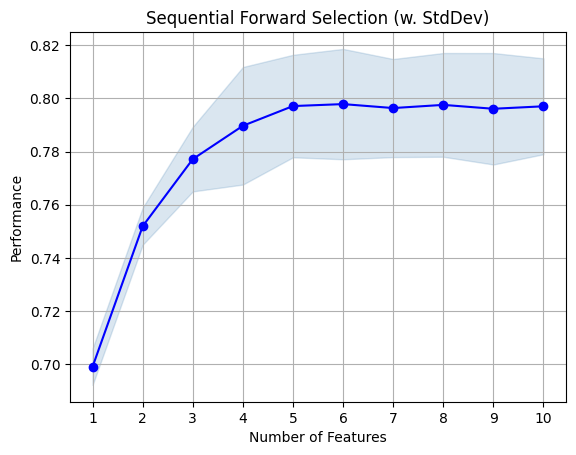

<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sfs.png") 

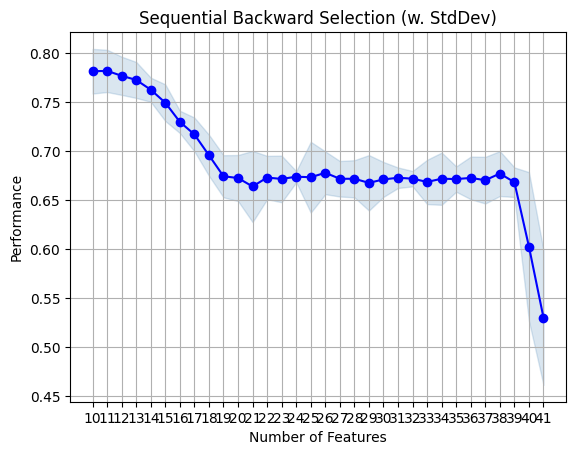

<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sbs.png") 

## Задача №2

In [25]:
interc_features = list(set(top_sbs) & set(top_sfs))
union_features = list(set(top_sbs) | set(top_sfs))

In [26]:
interc_features

['cat_tech_support_None',
 'cat_tech_support_No',
 'cat_payment_method_Electronic check',
 'cat_online_security_No',
 'cat_streaming_tv_None']

In [27]:
union_features

['cat_streaming_tv_No',
 'cat_multiple_lines_None',
 'cat_tech_support_No',
 'cat_device_protection_No',
 'cat_internet_service_Fiber optic',
 'cat_online_security_No',
 'cat_online_backup_Yes',
 'cat_paperless_billing_Yes',
 'cat_device_protection_None',
 'cat_tech_support_None',
 'cat_online_backup_No',
 'cat_payment_method_Electronic check',
 'cat_paperless_billing_No',
 'cat_streaming_tv_None',
 'cat_online_security_Yes']

## Задача №3

In [28]:
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(run_name=f"{RUN_NAME}_intersection_and_union", experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_artifacts(FS_ASSETS) 

2024-03-29 19:51:11,820 INFO: Found credentials in environment variables.


## Задача №4

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss, confusion_matrix, roc_auc_score


def calculate_metrics(y_test, preds, probs):
    metrics = {}

    _, err1, _, err2 = confusion_matrix(y_test, preds, normalize='all').ravel()
    auc = roc_auc_score(y_test, probs)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    logloss = log_loss(y_test, preds)

    metrics["err1"] = err1
    metrics["err2"] = err2
    metrics["auc"] = auc
    metrics["precision"] = precision
    metrics["recall"] = recall
    metrics["f1"] = f1
    metrics["logloss"] = logloss
    
    return metrics

In [37]:
model_inter = LogisticRegression()
model_inter.fit(X_train_features[interc_features], y_train)
preds_inter = model_inter.predict(X_test_features[interc_features])
probs_inter = model_inter.predict_proba(X_test_features[interc_features])[:,1]
metrics_inter = calculate_metrics(y_test, preds_inter, probs_inter)

In [59]:
REGISTRY_MODEL_NAME = "churn_model_feature_union_interc"
RUN_NAME = "feature_selection_intersection"

mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

pip_requirements = "./requirements.txt"
signature = mlflow.models.infer_signature(X_test_features[interc_features].values, y_test)
input_example = X_test_features[interc_features].head(10)
metadata = {"model_type": "logistic_regression"}

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_metrics(metrics_inter)
    model_info = mlflow.sklearn.log_model(
        sk_model = model_inter,
        artifact_path = "models",
        signature = signature,
        input_example = input_example,
        pip_requirements = pip_requirements,
        metadata = metadata,
        registered_model_name=REGISTRY_MODEL_NAME,
        await_registration_for=60
    )

/home/mle-user/mle_projects/mle-mlflow/.venv_mle_flow/lib/python3.10/site-packages/mlflow/models/signature.py:213: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  outputs = _infer_schema(model_output) if model_output is not None else None
Successfully registered model 'churn_model_feature_union_interc'.
2024/03/29 20:32:06 INFO mlflow.tracking._model_registry.client: Waiting 

In [61]:
model_union = LogisticRegression()
model_union.fit(X_train_features[union_features], y_train)
preds_union = model_union.predict(X_test_features[union_features])
probs_union = model_union.predict_proba(X_test_features[union_features])[:,1]
metrics_union = calculate_metrics(y_test, preds_union, probs_union)

In [62]:
REGISTRY_MODEL_NAME = "churn_model_feature_union_interc"
RUN_NAME = "feature_selection_union"

mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

pip_requirements = "./requirements.txt"
signature = mlflow.models.infer_signature(X_test_features[union_features].values, y_test)
input_example = X_test_features[union_features].head(10)
metadata = {"model_type": "logistic_regression"}

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_metrics(metrics_union)
    model_info = mlflow.sklearn.log_model(
        sk_model = model_union,
        artifact_path = "models",
        signature = signature,
        input_example = input_example,
        pip_requirements = pip_requirements,
        metadata = metadata,
        registered_model_name=REGISTRY_MODEL_NAME,
        await_registration_for=60
    )

/home/mle-user/mle_projects/mle-mlflow/.venv_mle_flow/lib/python3.10/site-packages/mlflow/models/signature.py:213: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  outputs = _infer_schema(model_output) if model_output is not None else None
Registered model 'churn_model_feature_union_interc' already exists. Creating a new version of this model...
2024/03/29 20:32:15 INFO mlflow